In [1]:
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
import numpy as np

Batch_Size=24
Image_Size=256
Channels=3
Epochs=20

dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "D:/VSCode/AI & ML Project/Dataset/Bell Pepper",
    shuffle=True,
    image_size=(Image_Size,Image_Size),
    batch_size= Batch_Size
)

Found 2475 files belonging to 2 classes.


In [2]:
class_names= dataset.class_names
class_names

['Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy']

In [3]:
def get_dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    ds_size= len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=10)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

train_ds,test_ds,val_ds = get_dataset_split(dataset)
print(len(train_ds),len(test_ds),len(val_ds))

83 11 10


In [4]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)#loading to cache memory to reduce training time
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_and_rescale =tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),#resizing
    layers.experimental.preprocessing.Rescaling(1.0/255)#normalizing
])

data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3)
])

input_shape=(Batch_Size,Image_Size,Image_Size,Channels)
n_classes=2
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),#relu makes model non linear by converting negative values in feature map to 0
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [5]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

data=model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs
)

Epoch 1/20
83/83 [==============================] - 81s 941ms/step - loss: 0.6519 - accuracy: 0.6489 - val_loss: 0.9438 - val_accuracy: 0.5958
Epoch 2/20
83/83 [==============================] - 74s 887ms/step - loss: 0.2795 - accuracy: 0.9168 - val_loss: 0.1377 - val_accuracy: 0.9542
Epoch 3/20
83/83 [==============================] - 73s 881ms/step - loss: 0.1352 - accuracy: 0.9650 - val_loss: 0.1297 - val_accuracy: 0.9458
Epoch 4/20
83/83 [==============================] - 75s 899ms/step - loss: 0.1136 - accuracy: 0.9716 - val_loss: 0.0539 - val_accuracy: 0.9875
Epoch 5/20
83/83 [==============================] - 74s 889ms/step - loss: 0.0783 - accuracy: 0.9772 - val_loss: 0.0224 - val_accuracy: 0.9958
Epoch 6/20
83/83 [==============================] - 73s 876ms/step - loss: 0.0444 - accuracy: 0.9909 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/20
83/83 [==============================] - 73s 874ms/step - loss: 0.0630 - accuracy: 0.9833 - val_loss: 0.0590 - val_accuracy: 0.9708

In [6]:
model.save("AI & ML Project/models/bellpepper")

INFO:tensorflow:Assets written to: AI & ML Project/models/bellpepper\assets


INFO:tensorflow:Assets written to: AI & ML Project/models/bellpepper\assets


In [7]:
scores=model.evaluate(test_ds)

11/11 [==============================] - 3s 194ms/step - loss: 0.0417 - accuracy: 0.9924


1/1 [==============================] - 0s 455ms/step
Predicted Disease Pepper,_bell___Bacterial_spot


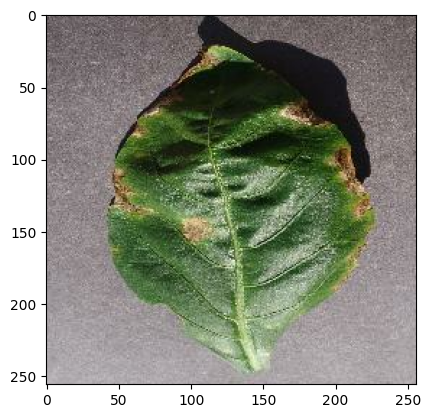

In [9]:
model=tf.keras.models.load_model("D:/VSCode/AI & ML Project/models/bellpepper")

for images_batch,labels_batch in test_ds.take(1):
    image=images_batch[0].numpy().astype("uint8")
    plt.imshow(image)

batch_prediction= model.predict(images_batch)
print("Predicted Disease",class_names[np.argmax(batch_prediction[0])])